# **NEW**

Please upload a sports image:


Saving Football_in_Bloomington,_Indiana,_1995.jpg to Football_in_Bloomington,_Indiana,_1995 (5).jpg


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master



0: 448x640 6 persons, 1 sports ball, 71.3ms
Speed: 5.0ms preprocess, 71.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Bắt đầu phân tích biểu cảm...
Bắt đầu phân tích biểu cảm...
MTCNN phát hiện 3 khuôn mặt
Bỏ qua khuôn mặt nhỏ 12x17 (0.1%)
Khuôn mặt kích thước 26x30 (0.4%) đạt yêu cầu
Khuôn mặt kích thước 34x39 (0.7%) đạt yêu cầu
Mặt 0: size=26x30, score=0.295
Mặt 1: size=34x39, score=0.234
Đã chọn khuôn mặt 0 làm khuôn mặt tốt nhất (score=0.295)
Khuôn mặt tốt nhất: face_debug/best_face.jpg
Phân tích cảm xúc với Computer Vision Features...
Ngữ cảnh thể thao: Có
Đối tượng thể thao: sports ball
Phát hiện cảm xúc bằng Computer Vision Features: surprise
Cường độ cảm xúc: 0.70
Phân tích biểu cảm thành công: True


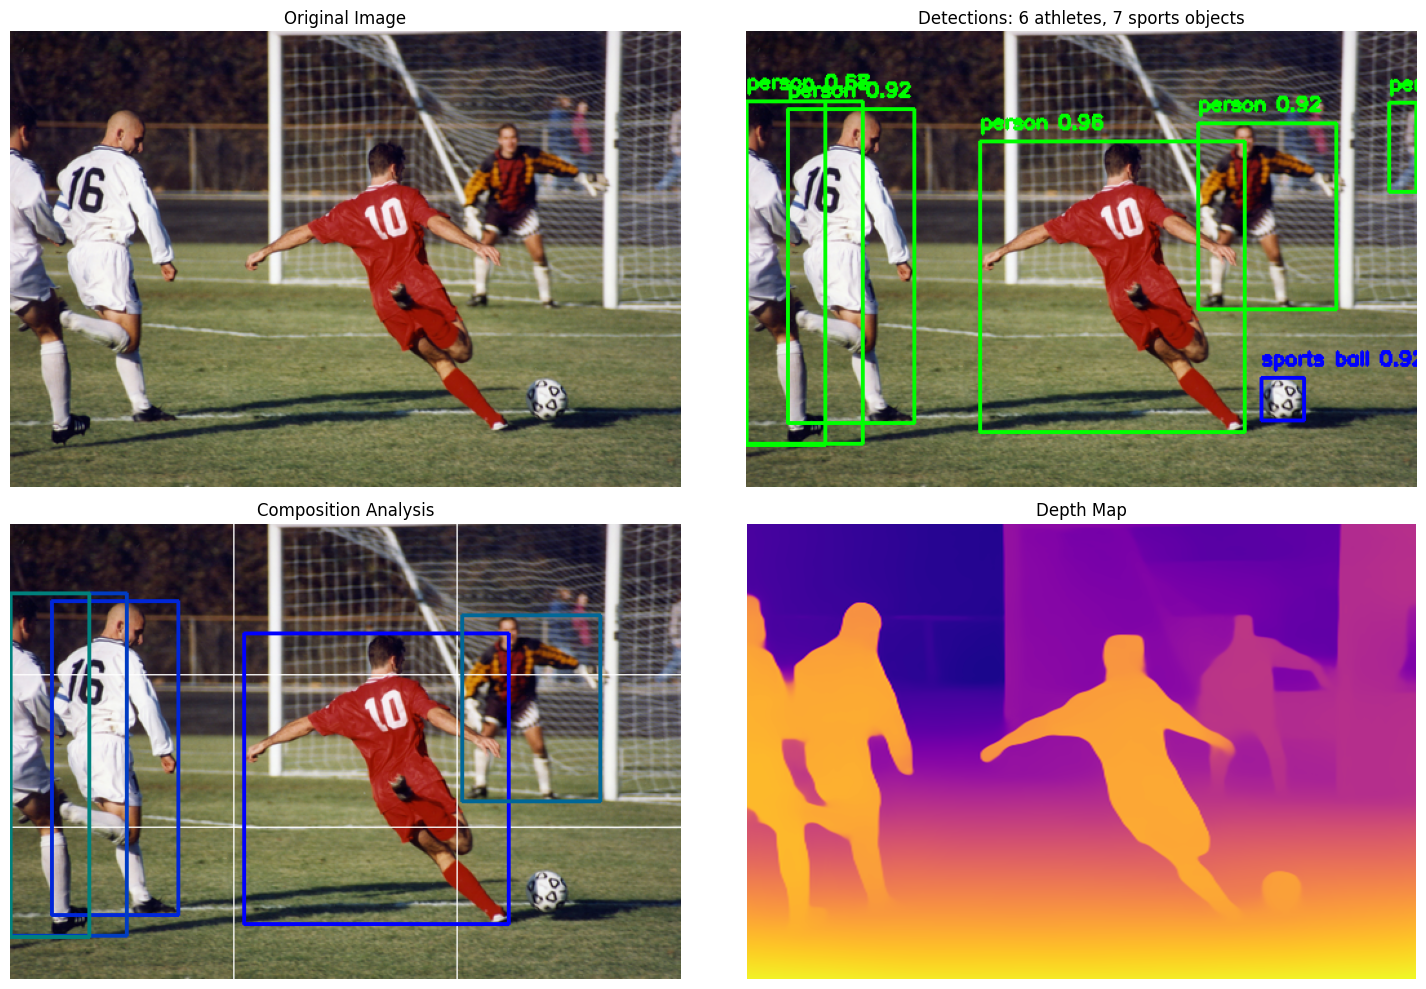


==== SPORTS IMAGE ANALYSIS ====
Detected 6 athletes and 1 other objects

Sport type: Ball Sport

Player Analysis:
- Number of players: 6
- Player dispersion: 0.49

Action Analysis:
- Equipment detected: sports ball
- Action level: High (0.93)

Composition Analysis:
- Framing quality: Could be improved

Key Subjects by Prominence:
1. person (Prominence: 0.23)
2. person (Prominence: 0.09)
3. person (Prominence: 0.08)
4. person (Prominence: 0.06)
5. person (Prominence: 0.05)

Phân tích biểu cảm:
- Cảm xúc chủ đạo: surprise
- Cường độ cảm xúc: 0.70
- Giá trị cảm xúc: Very High

Analysis completed in 36.01 seconds


In [47]:
import torch, os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from scipy import ndimage
from google.colab import files
import time

# Install required libraries
try:
    from segment_anything import sam_model_registry, SamPredictor
except ModuleNotFoundError:
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    from segment_anything import sam_model_registry, SamPredictor

# Install YOLO if not available
try:
    from ultralytics import YOLO
except ModuleNotFoundError:
    !pip install ultralytics
    from ultralytics import YOLO

# Download SAM model if needed
sam_checkpoint = "sam_vit_h_4b8939.pth"
if not os.path.exists(sam_checkpoint):
    !wget -O sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_models():
    # Load SAM model
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam.to(device)
    sam_predictor = SamPredictor(sam)

    # Load MiDaS depth model
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
    midas.to(device)
    midas.eval()

    # Load YOLO model for object detection
    yolo = YOLO("yolov8x.pt")  # Load the largest YOLOv8 model

    return sam_predictor, midas, yolo

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)

    # Resize keeping aspect ratio
    width, height = img.size
    ratio = min(520 / width, 520 / height)
    new_size = (int(width * ratio), int(height * ratio))
    resized_img = img.resize(new_size, Image.LANCZOS)

    # Process for MiDaS
    midas_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((384, 384), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    midas_input = midas_transform(img).unsqueeze(0).to(device)

    return {
        'original': img, 'array': img_array,
        'resized': resized_img, 'resized_array': np.array(resized_img),
        'midas_input': midas_input
    }

def detect_sports_objects(yolo, img_data):
    """Detect sports-related objects using YOLO"""
    results = yolo(img_data['resized_array'], conf=0.25)

    # Extract detections
    boxes = []
    classes = []
    scores = []
    sports_classes = ['person', 'sports ball', 'tennis racket', 'baseball bat', 'baseball glove',
                      'skateboard', 'surfboard', 'tennis ball', 'bottle', 'wine glass', 'cup',
                      'frisbee', 'skis', 'snowboard', 'kite']

    result = results[0]  # First image result

    detections = {
        'boxes': [],
        'classes': [],
        'scores': [],
        'sports_objects': 0,
        'athletes': 0
    }

    if hasattr(result, 'boxes') and len(result.boxes) > 0:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            class_name = result.names[cls]

            detections['boxes'].append([x1, y1, x2, y2])
            detections['classes'].append(class_name)
            detections['scores'].append(conf)

            if class_name == 'person':
                detections['athletes'] += 1
            if class_name in sports_classes:
                detections['sports_objects'] += 1

    return detections

def generate_depth_map(midas, img_data):
    with torch.no_grad():
        depth_map = midas(img_data['midas_input'])
        depth_map = torch.nn.functional.interpolate(
            depth_map.unsqueeze(1),
            size=img_data['array'].shape[:2],
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()

    normalized_depth = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-5)

    depth_8bit = (normalized_depth * 255).astype(np.uint8)
    _, depth_mask = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    depth_mask = cv2.morphologyEx(depth_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(depth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    main_contour = max(contours, key=cv2.contourArea) if contours else None

    return normalized_depth, depth_mask, main_contour

def segment_with_sam(sam_predictor, img_data):
    sam_predictor.set_image(img_data['resized_array'])

    height, width = img_data['resized_array'].shape[:2]
    points = []
    grid_size = 3

    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            points.append([width // (grid_size + 1) * i, height // (grid_size + 1) * j])
    points.append([width // 2, height // 2])

    input_points = np.array(points)
    input_labels = np.ones(len(input_points), dtype=int)

    masks, scores, _ = sam_predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True
    )

    best_mask = masks[np.argmax(scores)].astype(np.uint8)
    if np.mean(best_mask) > 0.5:
        best_mask = 1 - best_mask

    labeled, num = ndimage.label(best_mask)
    if num > 1:
        sizes = ndimage.sum(best_mask, labeled, range(1, num + 1))
        best_mask = (labeled == np.argmax(sizes) + 1).astype(np.uint8)

    color_mask = np.zeros((best_mask.shape[0], best_mask.shape[1], 3), dtype=np.uint8)
    color_mask[best_mask == 1] = [0, 255, 0]

    return best_mask, color_mask

def analyze_sports_scene(detections, depth_map, img_data):
    """Analyze the sports scene based on detected objects and depth"""
    height, width = depth_map.shape[:2]  # Lấy kích thước từ depth_map thay vì img_data

    # Analyze player distribution
    player_positions = []
    for i, cls in enumerate(detections['classes']):
        if cls == 'person':
            x1, y1, x2, y2 = detections['boxes'][i]
            # Chuyển đổi tọa độ hộp giới hạn để phù hợp với kích thước depth_map
            x1 = int(x1 * depth_map.shape[1] / img_data['resized_array'].shape[1])
            y1 = int(y1 * depth_map.shape[0] / img_data['resized_array'].shape[0])
            x2 = int(x2 * depth_map.shape[1] / img_data['resized_array'].shape[1])
            y2 = int(y2 * depth_map.shape[0] / img_data['resized_array'].shape[0])

            center_x = (x1 + x2) / 2 / width
            center_y = (y1 + y2) / 2 / height
            player_positions.append((center_x, center_y))

    # Khởi tạo player_dispersion với giá trị mặc định
    player_dispersion = 0

    # Calculate player dispersion (if multiple players)
    if len(player_positions) > 1:
        # Calculate average pairwise distance
        total_distance = 0
        count = 0
        for i in range(len(player_positions)):
            for j in range(i+1, len(player_positions)):
                p1 = player_positions[i]
                p2 = player_positions[j]
                dist = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
                total_distance += dist
                count += 1
        if count > 0:
            player_dispersion = total_distance / count

    # Identify key subjects (based on size and position)
    key_subjects = []
    for i, box in enumerate(detections['boxes']):
        x1, y1, x2, y2 = box
        area = (x2-x1) * (y2-y1)
        area_ratio = area / (img_data['resized_array'].shape[1] * img_data['resized_array'].shape[0])

        # Chuyển đổi tọa độ để phù hợp với depth_map
        depth_x1 = int(x1 * depth_map.shape[1] / img_data['resized_array'].shape[1])
        depth_y1 = int(y1 * depth_map.shape[0] / img_data['resized_array'].shape[0])
        depth_x2 = int(x2 * depth_map.shape[1] / img_data['resized_array'].shape[1])
        depth_y2 = int(y2 * depth_map.shape[0] / img_data['resized_array'].shape[0])

        # Đảm bảo các tọa độ nằm trong giới hạn của depth_map
        depth_x1 = max(0, min(depth_x1, depth_map.shape[1]-1))
        depth_y1 = max(0, min(depth_y1, depth_map.shape[0]-1))
        depth_x2 = max(0, min(depth_x2, depth_map.shape[1]-1))
        depth_y2 = max(0, min(depth_y2, depth_map.shape[0]-1))

        # Tạo mask với kích thước của depth_map
        mask = np.zeros((depth_map.shape[0], depth_map.shape[1]), dtype=np.uint8)
        if depth_y2 > depth_y1 and depth_x2 > depth_x1:  # Đảm bảo hộp có kích thước hợp lệ
            mask[depth_y1:depth_y2, depth_x1:depth_x2] = 1

        # Tính toán độ sâu trung bình
        obj_depth = np.mean(depth_map[mask > 0]) if np.sum(mask) > 0 else 0

        subject_info = {
            'class': detections['classes'][i],
            'box': box,
            'area_ratio': area_ratio,
            'depth': obj_depth,
            'position': ((x1+x2)/2/img_data['resized_array'].shape[1],
                         (y1+y2)/2/img_data['resized_array'].shape[0])
        }

        # Add prominence score based on size and position
        center_dist = np.sqrt((subject_info['position'][0]-0.5)**2 +
                             (subject_info['position'][1]-0.5)**2)
        subject_info['prominence'] = area_ratio * (1 - center_dist)

        key_subjects.append(subject_info)

    # Sort by prominence
    key_subjects.sort(key=lambda x: x['prominence'], reverse=True)

    return {
        'player_count': detections['athletes'],
        'player_positions': player_positions,
        'player_dispersion': player_dispersion,
        'key_subjects': key_subjects[:5] if key_subjects else []
    }

def analyze_action_quality(detections, img_data):
    """Phân tích chất lượng hành động trong ảnh thể thao với cách tiếp cận cải tiến"""
    height, width = img_data['resized_array'].shape[:2]

    # 1. Kiểm tra thiết bị thể thao (giữ nguyên như cũ)
    has_equipment = False
    equipment_types = []
    for cls in detections['classes']:
        if cls in ['sports ball', 'tennis racket', 'baseball bat', 'baseball glove',
                  'skateboard', 'surfboard', 'tennis ball', 'frisbee', 'skis', 'snowboard']:
            has_equipment = True
            if cls not in equipment_types:
                equipment_types.append(cls)

    # 2. Phân tích tư thế cá nhân thay vì so sánh giữa nhiều người
    action_posture_score = 0
    dynamic_posture_count = 0
    total_players = 0

    for i, cls in enumerate(detections['classes']):
        if cls == 'person':
            total_players += 1
            x1, y1, x2, y2 = detections['boxes'][i]

            # a. Tính tỷ lệ chiều cao/chiều rộng
            aspect_ratio = (y2-y1)/(x2-x1) if (x2-x1) > 0 else 0

            # b. Đánh giá tư thế dựa trên tỷ lệ khung hình
            # Tư thế không điển hình (có thể đang nhảy, cúi, nằm...)
            if aspect_ratio < 1.2 or aspect_ratio > 2.5:
                dynamic_posture_count += 1

            # c. Tính diện tích tương đối (lớn = hành động gần hơn)
            area_ratio = ((y2-y1) * (x2-x1)) / (height * width)
            if area_ratio > 0.2:  # Vận động viên chiếm diện tích lớn, thường là hành động gần
                action_posture_score += 0.2

    # Nếu có người trong tư thế không điển hình, đó có thể là hành động năng động
    if total_players > 0:
        dynamic_posture_ratio = dynamic_posture_count / total_players
        action_posture_score += dynamic_posture_ratio * 0.5

    # 3. Tính action_level cải tiến
    action_level = 0

    # Nếu có thiết bị thể thao (giữ nguyên)
    if has_equipment:
        action_level += 0.4

    # Thêm điểm từ phân tích tư thế
    action_level += min(0.6, action_posture_score)

    # 4. Phân loại chất lượng hành động
    return {
        'has_equipment': has_equipment,
        'equipment_types': equipment_types,
        'dynamic_posture_score': action_posture_score,
        'dynamic_posture_count': dynamic_posture_count,
        'total_players': total_players,
        'action_level': action_level,
        'action_quality': "High" if action_level > 0.7 else
                         "Medium" if action_level > 0.3 else "Low"
    }

def analyze_sports_composition(detections, analysis, img_data):
    """Analyze the composition with sports-specific context"""

    # Basic composition from existing analysis
    composition = analysis["composition_analysis"] if "composition_analysis" in analysis else {}

    # Sports specific enhancements
    result = {
        'sport_type': 'Unknown',
        'framing_quality': 'Unknown',
        'recommended_crop': None,
        'action_focus': 'Unknown'
    }

    # Try to determine sport type
    sport_equipment = {
        'tennis racket': 'Tennis',
        'tennis ball': 'Tennis',
        'sports ball': 'Ball Sport',
        'baseball bat': 'Baseball',
        'baseball glove': 'Baseball',
        'skateboard': 'Skateboarding',
        'surfboard': 'Surfing',
        'frisbee': 'Frisbee',
        'skis': 'Skiing',
        'snowboard': 'Snowboarding'
    }

    for cls in detections['classes']:
        if cls in sport_equipment:
            result['sport_type'] = sport_equipment[cls]
            break

    # Evaluate framing quality for sports action
    if "key_subjects" in analysis and analysis['key_subjects']:
        subject_positions = [subject['position'] for subject in analysis['key_subjects']]

        # Check if key subjects are well placed (rule of thirds or centered)
        well_placed_count = 0
        for pos in subject_positions:
            # Check rule of thirds points
            thirds_points = [
                (1/3, 1/3), (2/3, 1/3),
                (1/3, 2/3), (2/3, 2/3)
            ]

            center_point = (0.5, 0.5)

            # Check if close to rule of thirds points or center
            for third in thirds_points:
                dist = np.sqrt((pos[0]-third[0])**2 + (pos[1]-third[1])**2)
                if dist < 0.1:  # 10% of image width/height
                    well_placed_count += 1
                    break

            # Check if centered
            dist_to_center = np.sqrt((pos[0]-center_point[0])**2 + (pos[1]-center_point[1])**2)
            if dist_to_center < 0.1:
                well_placed_count += 1

        if well_placed_count / len(subject_positions) > 0.7:
            result['framing_quality'] = 'Excellent'
        elif well_placed_count / len(subject_positions) > 0.4:
            result['framing_quality'] = 'Good'
        else:
            result['framing_quality'] = 'Could be improved'

    # Recommend crop if needed
    if "key_subjects" in analysis and analysis['key_subjects']:
        main_subject = analysis['key_subjects'][0]
        x_pos = main_subject['position'][0]
        y_pos = main_subject['position'][1]

        # If subject is too far from ideal positions, suggest crop
        if not (0.3 < x_pos < 0.7 or 0.3 < y_pos < 0.7):
            # Calculate ideal center point
            if x_pos < 0.33:
                ideal_x = 0.33
            elif x_pos > 0.67:
                ideal_x = 0.67
            else:
                ideal_x = 0.5

            if y_pos < 0.33:
                ideal_y = 0.33
            elif y_pos > 0.67:
                ideal_y = 0.67
            else:
                ideal_y = 0.5

            # Calculate shift needed
            shift_x = ideal_x - x_pos
            shift_y = ideal_y - y_pos

            result['recommended_crop'] = {
                'shift_x': shift_x,
                'shift_y': shift_y
            }

    # Evaluate action focus
    if "action_quality" in analysis:
        result['action_focus'] = analysis['action_quality']

    return result
def analyze_facial_expression_optimized(detections, img_data):
    """Phân tích biểu cảm khuôn mặt sử dụng MTCNN - phiên bản tối ưu"""
    try:
        print("Bắt đầu phân tích biểu cảm...")

        import cv2
        import numpy as np
        import os

        # Cài đặt MTCNN
        try:
            from mtcnn import MTCNN
            detector = MTCNN()
        except ImportError:
            !pip install mtcnn
            from mtcnn import MTCNN
            detector = MTCNN()

        image = img_data['resized_array']

        # Kết quả mặc định
        expression_results = {
            'has_faces': False,
            'expressions': [],
            'dominant_emotion': 'unknown',
            'emotion_intensity': 0,
            'emotional_value': 'Low'
        }

        # Phát hiện khuôn mặt với MTCNN
        faces = detector.detect_faces(image)
        print(f"MTCNN phát hiện {len(faces)} khuôn mặt")

        # Lọc khuôn mặt quá nhỏ
        img_area = image.shape[0] * image.shape[1]
        valid_faces = []

        for face in faces:
            x, y, w, h = face['box']
            face_area_percent = (w * h * 100) / img_area

            # Chỉ chấp nhận khuôn mặt chiếm ít nhất 3% diện tích ảnh để đảm bảo phân tích chính xác
            if face_area_percent >= 0.2 and w >= 20 and h >= 20:
                valid_faces.append(face)
                print(f"Khuôn mặt kích thước {w}x{h} ({face_area_percent:.1f}%) đạt yêu cầu")
            else:
                print(f"Bỏ qua khuôn mặt nhỏ {w}x{h} ({face_area_percent:.1f}%)")

        if not valid_faces:
            print("Không có khuôn mặt đạt kích thước tối thiểu để phân tích")
            return expression_results

        # Tạo thư mục debug
        debug_dir = "face_debug"
        if not os.path.exists(debug_dir):
            os.makedirs(debug_dir)

        # Tìm khuôn mặt tốt nhất
        best_face = None
        best_score = -1

        for i, face in enumerate(valid_faces):
            x, y, w, h = face['box']
            conf = face['confidence']

            # Tính điểm dựa trên kích thước + vị trí trung tâm + độ tin cậy
            center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
            face_center_x, face_center_y = x + w/2, y + h/2
            size_score = w * h / (image.shape[0] * image.shape[1])

            # Tính khoảng cách đến trung tâm
            max_distance = np.sqrt(image.shape[1]**2 + image.shape[0]**2) / 2
            distance = np.sqrt((face_center_x - center_x)**2 + (face_center_y - center_y)**2)
            center_score = 1.0 - min(1.0, distance / max_distance)

            # Tính điểm tổng hợp
            score = size_score * 0.5 + center_score * 0.3 + conf * 0.2

            print(f"Mặt {i}: size={w}x{h}, score={score:.3f}")

            # Lưu khuôn mặt để debug
            face_img = image[max(0, y):min(y+h, image.shape[0]), max(0, x):min(x+w, image.shape[1])]
            face_path = f"{debug_dir}/face_{i}_score_{score:.3f}.jpg"
            cv2.imwrite(face_path, cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))

            if score > best_score:
                best_score = score
                best_face = {
                    'index': i,
                    'box': (x, y, w, h),
                    'confidence': conf,
                    'img': face_img
                }

        # Lấy khuôn mặt tốt nhất
        if not best_face:
            print("Không tìm thấy khuôn mặt tốt nhất")
            return expression_results

        x, y, w, h = best_face['box']
        print(f"Đã chọn khuôn mặt {best_face['index']} làm khuôn mặt tốt nhất (score={best_score:.3f})")

        # Mở rộng vùng khuôn mặt
        x1 = max(0, x - int(w * 0.1))
        y1 = max(0, y - int(h * 0.1))
        x2 = min(image.shape[1], x + w + int(w * 0.1))
        y2 = min(image.shape[0], y + h + int(h * 0.1))
        face_img = image[y1:y2, x1:x2]

        # Lưu khuôn mặt tốt nhất
        best_face_path = f"{debug_dir}/best_face.jpg"
        cv2.imwrite(best_face_path, cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))
        print(f"Khuôn mặt tốt nhất: {best_face_path}")

        # Đánh dấu đã tìm thấy khuôn mặt
        expression_results['has_faces'] = True

        # PHÂN TÍCH CẢM XÚC - DÙNG COMPUTER VISION FEATURES
        print("Phân tích cảm xúc với Computer Vision Features...")

        # Chuyển sang ảnh xám và tính toán các đặc trưng
        gray = cv2.cvtColor(face_img, cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray) / 255.0
        contrast = np.std(gray) / 128.0

        # Tính histogram của ảnh (đơn giản hóa)
        hist = cv2.calcHist([gray], [0], None, [8], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # Tính gradient ảnh (tính texture)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_mean = np.mean(np.sqrt(sobelx**2 + sobely**2)) / 128.0

        # Chia ảnh thành các vùng
        h, w = gray.shape
        top = gray[:h//3, :]  # Vùng trán/mắt
        middle = gray[h//3:2*h//3, :]  # Vùng mũi
        bottom = gray[2*h//3:, :]  # Vùng miệng/cằm

        # Tính toán đặc trưng theo vùng
        top_contrast = np.std(top) / 128.0
        middle_contrast = np.std(middle) / 128.0
        bottom_contrast = np.std(bottom) / 128.0

        # PHƯƠNG PHÁP CẢI TIẾN CHO THỂ THAO: Đánh giá cảm xúc dựa trên ngữ cảnh

        # Khởi tạo cảm xúc với giá trị cơ bản
        emotions = {
            'neutral': 0.10,
            'happiness': 0.10,
            'surprise': 0.10,
            'sadness': 0.10,
            'anger': 0.10,
            'fear': 0.10,
            'disgust': 0.10
        }

        # 1. Phân tích ngữ cảnh thể thao từ đối tượng phát hiện được
        is_sports_context = False
        sports_objects = []

        if isinstance(detections, dict) and 'classes' in detections:
            sports_keywords = ['sports ball', 'tennis', 'baseball', 'basketball', 'football',
                              'racket', 'bat', 'athlete', 'player', 'stadium', 'court']

            for obj in detections.get('classes', []):
                for keyword in sports_keywords:
                    if keyword in str(obj).lower():
                        is_sports_context = True
                        sports_objects.append(obj)

        # 2. Điều chỉnh cảm xúc dựa vào ngữ cảnh thể thao
        print(f"Ngữ cảnh thể thao: {'Có' if is_sports_context else 'Không'}")
        if is_sports_context:
            print(f"Đối tượng thể thao: {', '.join(str(o) for o in sports_objects)}")
            # Thể thao thường liên quan đến cảm xúc tích cực hoặc mạnh mẽ
            #emotions['happiness'] += 0.15
            #emotions['surprise'] += 0.10

        # 3. Phân tích vùng miệng (quan trọng cho biểu cảm)
        if bottom_contrast > 0.20:  # Độ tương phản cao ở miệng
            if brightness > 0.45:  # Miệng sáng - có thể đang cười
                emotions['happiness'] += 0.25
            else:  # Miệng tối - có thể đang hét/la
                emotions['surprise'] += 0.20
                emotions['anger'] += 0.10

        # 4. Phân tích vùng mắt
        if top_contrast > 0.18:  # Mắt rõ ràng
            if is_sports_context:  # Ngữ cảnh thể thao + mắt rõ = tập trung/phấn khích
                emotions['surprise'] += 0.15
                emotions['fear'] += 0.05  # Căng thẳng thi đấu
            else:
                emotions['surprise'] += 0.10

        # 5. Độ sáng tổng thể
        if brightness > 0.6:  # Sáng -> vui vẻ/tích cực
            emotions['happiness'] += 0.15
            emotions['neutral'] -= 0.05
        elif brightness < 0.4:  # Tối -> nghiêm túc/tiêu cực
            emotions['sadness'] += 0.10
            emotions['anger'] += 0.05
            emotions['happiness'] -= 0.05

        # 6. Texture mạnh (gradient cao) -> biểu cảm mạnh
        if gradient_mean > 0.25:
            emotions['surprise'] += 0.15
            emotions['happiness'] += 0.05
            emotions['neutral'] -= 0.10

        # 7. Điều chỉnh dựa trên kích thước khuôn mặt
        face_area_percent = (w * h * 100) / img_area

        # Đảm bảo không có giá trị âm và chuẩn hóa tổng = 1
        emotions = {k: max(0.01, v) for k, v in emotions.items()}
        total = sum(emotions.values())
        emotions = {k: v/total for k, v in emotions.items()}

        # Tìm cảm xúc chiếm ưu thế
        dominant_emotion = max(emotions, key=emotions.get)
        dominant_score = emotions[dominant_emotion]

        # Tính cường độ cảm xúc từ sự chênh lệch
        other_emotions = [v for k, v in emotions.items() if k != dominant_emotion]
        avg_other = sum(other_emotions) / len(other_emotions)
        intensity = max(0.2, min(0.95, 0.5 + (dominant_score - avg_other)))

        print(f"Phát hiện cảm xúc bằng Computer Vision Features: {dominant_emotion}")
        print(f"Cường độ cảm xúc: {intensity:.2f}")

        # Lưu kết quả
        expression_results['dominant_emotion'] = dominant_emotion
        expression_results['emotion_intensity'] = intensity
        expression_results['expressions'].append({
            'box': (x1, y1, x2, y2),
            'emotion': dominant_emotion,
            'scores': emotions
        })

        # Đánh giá giá trị cảm xúc
        if intensity > 0.7:
            expression_results['emotional_value'] = 'Very High'
        elif intensity > 0.5:
            expression_results['emotional_value'] = 'High'
        elif intensity > 0.3:
            expression_results['emotional_value'] = 'Medium'
        else:
            expression_results['emotional_value'] = 'Low'

        return expression_results

    except Exception as e:
        print(f"Lỗi phân tích biểu cảm: {str(e)}")
        return {'has_faces': False, 'error': str(e)}

def visualize_sports_results(img_data, detections, depth_map, sports_analysis, action_analysis, composition_analysis, facial_analysis=None):
    """Create sports-specific visualization"""
    img = np.array(img_data['resized']).copy()
    height, width = img.shape[:2]

    # Create detection visualization
    det_viz = img.copy()

    # Draw bounding boxes
    for i, box in enumerate(detections['boxes']):
        x1, y1, x2, y2 = box
        label = detections['classes'][i]
        conf = detections['scores'][i]

        # Different colors for different classes
        if label == 'person':
            color = (0, 255, 0)  # Green for people
        elif 'ball' in label:
            color = (0, 0, 255)  # Red for balls
        else:
            color = (255, 0, 0)  # Blue for other equipment

        cv2.rectangle(det_viz, (x1, y1), (x2, y2), color, 2)
        cv2.putText(det_viz, f"{label} {conf:.2f}", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Create composition analysis visualization
    comp_viz = img.copy()

    # Draw rule of thirds grid
    for i in range(1, 3):
        cv2.line(comp_viz, (0, int(height*i/3)), (width, int(height*i/3)), (255, 255, 255), 1)
        cv2.line(comp_viz, (int(width*i/3), 0), (int(width*i/3), height), (255, 255, 255), 1)

    # Draw key subjects with prominence
    if "key_subjects" in sports_analysis:
        for subject in sports_analysis['key_subjects']:
            box = subject['box']
            x1, y1, x2, y2 = box
            # Color based on prominence - more red = more important
            prominence = min(1.0, subject['prominence'] * 10)  # Scale for visibility
            color = (0, int(255 * (1-prominence)), int(255 * prominence))
            cv2.rectangle(comp_viz, (x1, y1), (x2, y2), color, 2)

    # Display results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(det_viz)
    plt.title(f"Detections: {detections['athletes']} athletes, {detections['sports_objects']} sports objects")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(comp_viz)
    plt.title("Composition Analysis")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(depth_map, cmap='plasma')
    plt.title("Depth Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n==== SPORTS IMAGE ANALYSIS ====")
    print(f"Detected {detections['athletes']} athletes and {len(detections['classes'])-detections['athletes']} other objects")

    if "sport_type" in composition_analysis:
        print(f"\nSport type: {composition_analysis['sport_type']}")

    if detections['athletes'] > 0:
        print("\nPlayer Analysis:")
        print(f"- Number of players: {detections['athletes']}")
        if detections['athletes'] > 1:
            print(f"- Player dispersion: {sports_analysis['player_dispersion']:.2f}")

    print("\nAction Analysis:")
    print(f"- Equipment detected: {', '.join(action_analysis['equipment_types']) if action_analysis['equipment_types'] else 'None'}")
    print(f"- Action level: {action_analysis['action_quality']} ({action_analysis['action_level']:.2f})")

    print("\nComposition Analysis:")
    print(f"- Framing quality: {composition_analysis['framing_quality']}")

    if composition_analysis['recommended_crop']:
        crop = composition_analysis['recommended_crop']
        direction_x = "right" if crop['shift_x'] < 0 else "left"
        direction_y = "down" if crop['shift_y'] < 0 else "up"
        print(f"- Recommended crop: Shift {abs(crop['shift_x'])*100:.1f}% {direction_x} and {abs(crop['shift_y'])*100:.1f}% {direction_y}")

    # Key subjects
    if sports_analysis['key_subjects']:
        print("\nKey Subjects by Prominence:")
        for i, subject in enumerate(sports_analysis['key_subjects']):
            print(f"{i+1}. {subject['class']} (Prominence: {subject['prominence']:.2f})")

    if facial_analysis and facial_analysis.get('has_faces', False):
        print("\nPhân tích biểu cảm:")
        print(f"- Cảm xúc chủ đạo: {facial_analysis['dominant_emotion']}")
        print(f"- Cường độ cảm xúc: {facial_analysis['emotion_intensity']:.2f}")
        print(f"- Giá trị cảm xúc: {facial_analysis['emotional_value']}")

def analyze_sports_image(file_path):
    """Main function to analyze sports images"""
    t_start = time.time()

    # Load models
    sam_predictor, midas, yolo = load_models()
    img_data = preprocess_image(file_path)

    # Step 1: Object detection with YOLO
    detections = detect_sports_objects(yolo, img_data)

    # Step 2: Generate depth map
    depth_map, depth_mask, depth_contour = generate_depth_map(midas, img_data)

    # Step 3: Optional - Segment with SAM if needed
    # seg_mask, color_mask = segment_with_sam(sam_predictor, img_data)

    # Step 4: Analyze sports scene
    sports_analysis = analyze_sports_scene(detections, depth_map, img_data)

    # Step 5: Analyze action quality
    action_analysis = analyze_action_quality(detections, img_data)

    # Step 6: Sports composition analysis
    composition_analysis = analyze_sports_composition(detections, sports_analysis, img_data)

    # Bổ sung: Phân tích biểu cảm (tuỳ chọn)
    # Thêm dòng này vào hàm analyze_sports_image() trước khi gọi analyze_facial_expression
    print("Bắt đầu phân tích biểu cảm...")
    try:
        facial_analysis = analyze_facial_expression_optimized(detections, img_data)
        print("Phân tích biểu cảm thành công:", facial_analysis.get('has_faces', False))
    except Exception as e:
        print(f"Chi tiết lỗi phân tích biểu cảm: {str(e)}")

    # Step 7: Visualize results - thêm facial_analysis vào tham số
    visualize_sports_results(img_data, detections, depth_map,
                            sports_analysis, action_analysis, composition_analysis,
                            facial_analysis)

    t_end = time.time()
    print(f"\nAnalysis completed in {t_end - t_start:.2f} seconds")

    return {
        'detections': detections,
        'sports_analysis': sports_analysis,
        'action_analysis': action_analysis,
        'composition_analysis': composition_analysis,
        'facial_analysis': facial_analysis
    }

def main():
    # Upload image
    print("Please upload a sports image:")
    uploaded = files.upload()
    file_name = next(iter(uploaded))

    # Analyze image
    analysis = analyze_sports_image(file_name)
    return analysis

if __name__ == "__main__":
    main()